# Matching Phase Utilizando o PSO
Casamento de fase aplicando o Simulador e o GA.

## Bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Imports específicos para o Gerador X (Holograma)
from scipy.fft import fft2, ifft2, fftshift, ifftshift

## Carregar Bibliotecas

Carrega as bibliotecas, filtra a altura para 600 nm e rotação igual a 0 graus, e cria um dataframe.

In [2]:
caminho_real_pkl = "/content/7lib.pkl"

try:
    df_real = pd.read_pickle(caminho_real_pkl)
    print(f"Biblioteca real carregada. Forma: {df_real.shape}")

    if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
        raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas no .pkl")

    df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
    df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

    print("Colunas 'S_complex_TM' (S24) e 'S_complex_TE' (S13) criadas com sucesso.")

    DEFAULT_HEIGHT = 600.0
    DEFAULT_ANGLE = 0.0

    df_filtrado_2D = df_real[
        (df_real['H'] == DEFAULT_HEIGHT) &
        (df_real['a'] == DEFAULT_ANGLE)
    ].copy()

    print(f"Biblioteca filtrada para 2D (H={DEFAULT_HEIGHT}, a={DEFAULT_ANGLE}). Nova forma: {df_filtrado_2D.shape}")

    if df_filtrado_2D.shape[0] == 0:
        raise ValueError("Filtragem resultou em 0 átomos. Verifique os valores DEFAULT_HEIGHT/ANGLE.")

    #Mudamos as colunas para os nomes que a NN trabalha
    df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
    df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])

    df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
    df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
    df = df_filtrado_2D

    print("\n--- Preparação de Dados Concluída ---")
    print("DataFrame 'df' está pronto para ser usado pela rede neural.")
    print(df[['L_x', 'L_y', 'Transmitancia_x', 'Fase_x', 'Transmitancia_y', 'Fase_y']].head())

except FileNotFoundError:
    print(f"\n--- ERRO: Arquivo NÃO encontrado ---")
    print(f"Verifique o caminho: '{caminho_real_pkl}'")
except KeyError as e:
    print(f"\n--- ERRO: Coluna não encontrada ---")
    print(f"Ocorreu um erro de chave: {e}.")
    print("Verifique se as colunas (ex: 'S24_real' ou 'S13_real') existem no .pkl.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Biblioteca real carregada. Forma: (5507, 54)
Colunas 'S_complex_TM' (S24) e 'S_complex_TE' (S13) criadas com sucesso.
Biblioteca filtrada para 2D (H=600.0, a=0.0). Nova forma: (2371, 56)

--- Preparação de Dados Concluída ---
DataFrame 'df' está pronto para ser usado pela rede neural.
      L_x   L_y  Transmitancia_x    Fase_x  Transmitancia_y    Fase_y
30   70.0  70.0         0.988019 -1.310207         0.988251 -1.310759
81   70.0  75.0         0.988320 -1.328479         0.989054 -1.359100
132  70.0  80.0         0.989101 -1.343390         0.990052 -1.411462
183  70.0  85.0         0.989206 -1.361828         0.991399 -1.474434
234  70.0  90.0         0.989365 -1.379114         0.993022 -1.546775


# Mapas de Fase

Criação do mapa de fase para a polarização x:

In [3]:
def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"Atenção: Imagem '{image_path}' não encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai região central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruída
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitária (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	Iteração GS (X) {i+1}/{num_iter}, Correlação: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	Iteração GS (X) 10/200, Correlação: 0.6681
 	Iteração GS (X) 20/200, Correlação: 0.6976
 	Iteração GS (X) 30/200, Correlação: 0.7096
 	Iteração GS (X) 40/200, Correlação: 0.7170
 	Iteração GS (X) 50/200, Correlação: 0.7221
 	Iteração GS (X) 60/200, Correlação: 0.7256
 	Iteração GS (X) 70/200, Correlação: 0.7280
 	Iteração GS (X) 80/200, Correlação: 0.7300
 	Iteração GS (X) 90/200, Correlação: 0.7316
 	Iteração GS (X) 100/200, Correlação: 0.7331
 	Iteração GS (X) 110/200, Correlação: 0.7345
 	Iteração GS (X) 120/200, Correlação: 0.7356
 	Iteração GS (X) 130/200, Correlação: 0.7367
 	Iteração GS (X) 140/200, Correlação: 0.7377
 	Iteração GS (X) 150/200, Correlação: 0.7386
 	Iteração GS (X) 160/200, Correlação: 0.7395
 	Iteração GS (X) 170/200, Correlação: 0.7402
 	Iteração GS (X) 180/200, Correlação: 0.7409
 	Iteração GS (X) 190/200, Correlação: 0.7414
 	Iteração GS (X) 200/200, Correlação: 0.7418

Corre

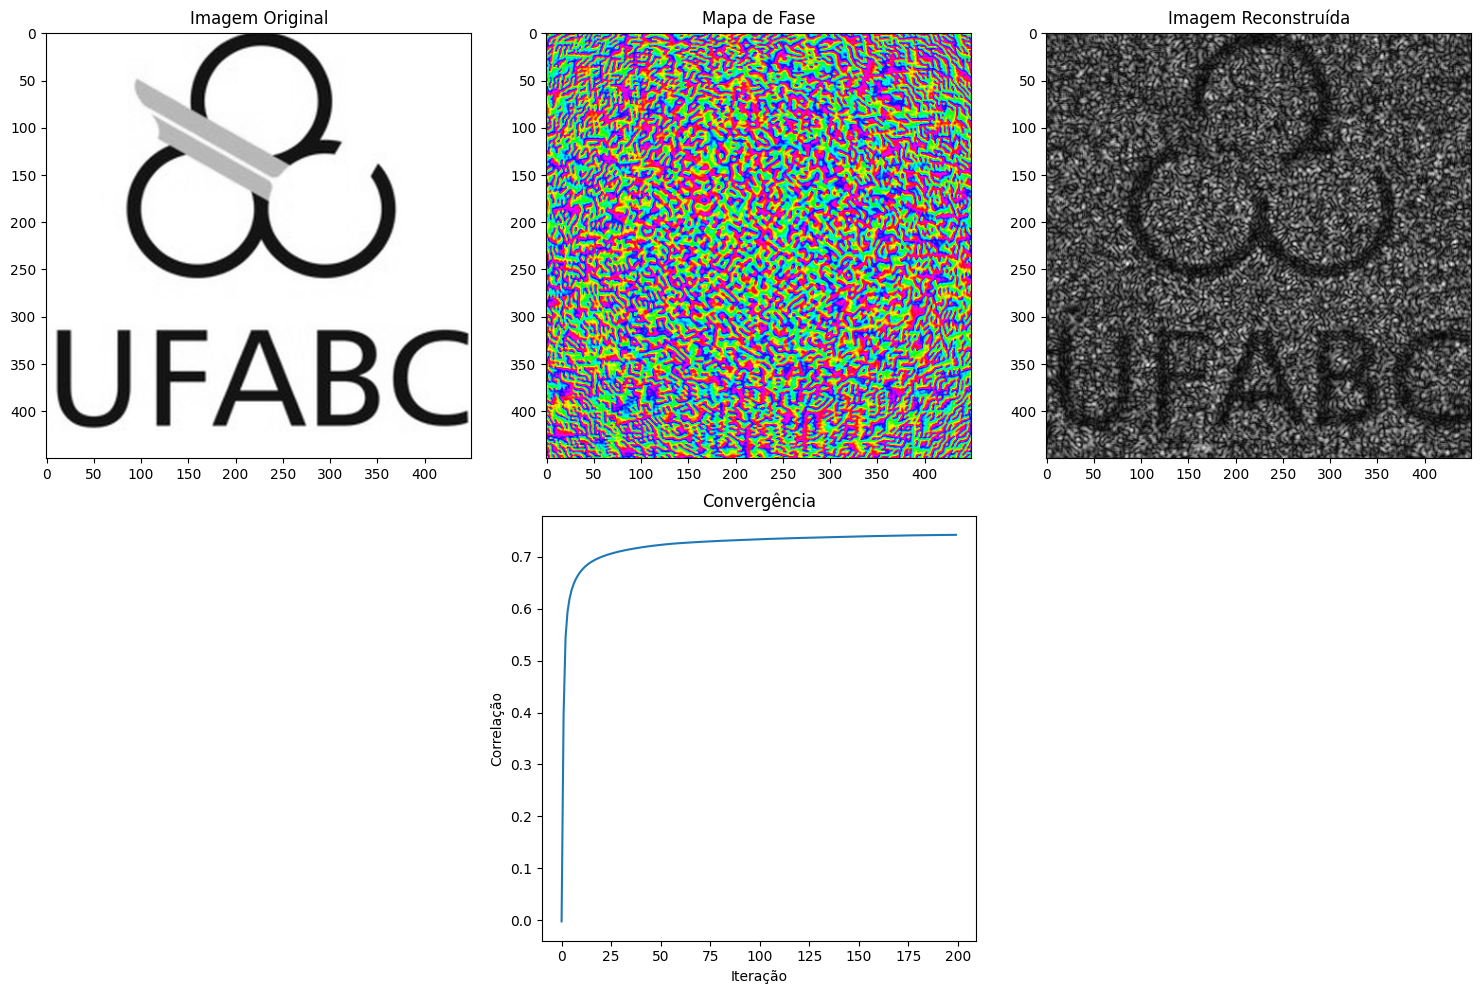

In [4]:
wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 μm
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 200       # número de iterações

print("Carregando e pré-processando imagem...")
target_original = load_and_preprocess_image('/content/WhatsApp Image 2025-11-06 at 16.18.47.png', target_size=(450, 450))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelação final: {correlations[-1]:.4f}")

print(f"Dimensões da Imagem Original: {img_original.shape}")
print(f"Dimensões da Imagem Reconstruída: {img_reconstruida.shape}")
print(f"Dimensões do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem Reconstruída')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('Convergência')
plt.xlabel('Iteração')
plt.ylabel('Correlação')

plt.tight_layout()
plt.show()

## Polarização y:

In [5]:
def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 10,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta função usa np.fft, o que não conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteração para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  Iterações GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- Construção da Metassuperfície Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geração de fase

    return full_phase, metrics, errors


Iniciando Geração de Fase...


  Mapa Dammann (Y) gerado: (450, 450) pixels
Geração de Fase Concluída.
Iniciando análise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
Análise: Calculando Far-Field da metassuperfície completa...
Análise: Extraindo ordens de difração...
Análise concluída. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  3.025955e+07 -897435.897436 -256410.256410
1 -21 -5  2.756224e+07 -897435.897436 -213675.213675
2 -21 -4  2.966075e+07 -897435.897436 -170940.170940
3 -21 -3  2.624582e+07 -897435.897436 -128205.128205
4 -21 -2  2.435471e+07 -897435.897436  -85470.085470


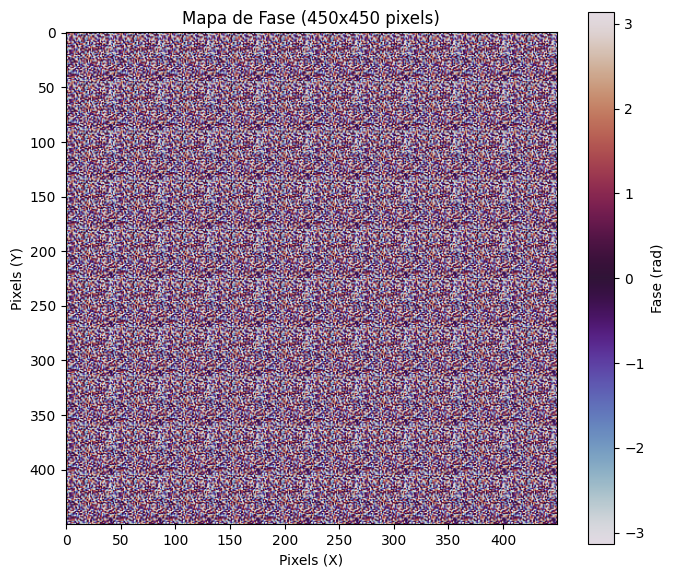

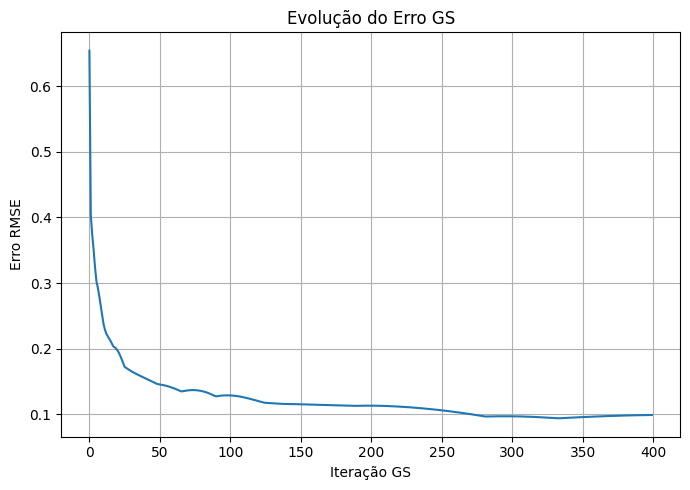

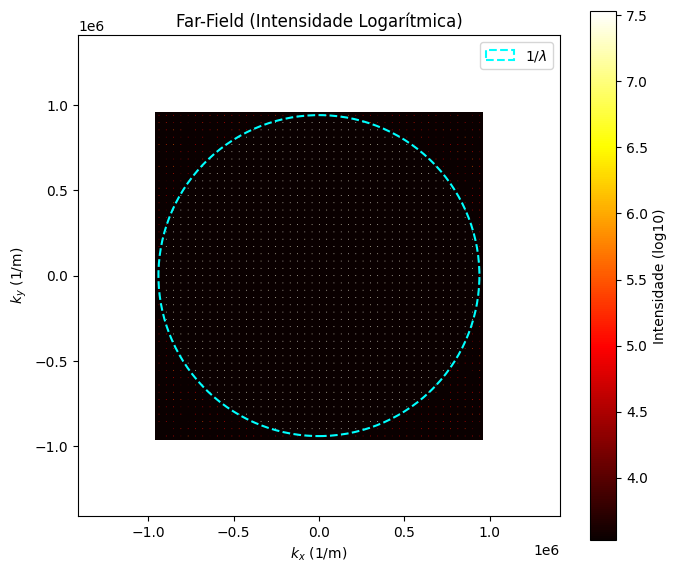

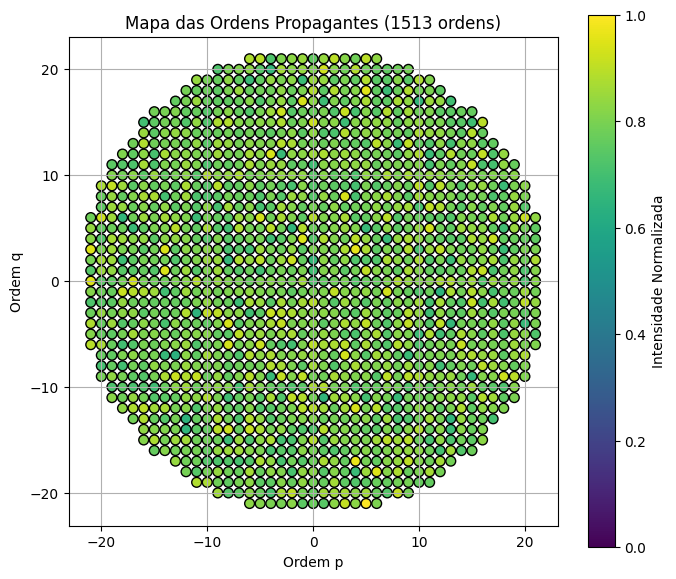

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# (Sua função generate_dammann_phase_map já deve estar definida acima)

def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfície.

    Esta função calcula o far-field, analisa as ordens de difração e
    gera os 4 plots principais (Mapa de Fase, Erro GS, Far-Field, Ordens).

    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando análise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: Evolução do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("Iteração GS")
    plt.ylabel("Erro RMSE")
    plt.title("Evolução do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- Análise de Far-Field (Células 8 & 9) ---
    print("Análise: Calculando Far-Field da metassuperfície completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("Análise: Extraindo ordens de difração...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"Análise concluída. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade Logarítmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 10
iters_gs = 400
random_seed = 0

print("Iniciando Geração de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("Geração de Fase Concluída.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

# Funções do Simulador

In [7]:
IMG_SIZE = 64
MAX_DIM_NM = 520

def draw_meta_atom_ellipse(L_x_nm, L_y_nm):
    """ Desenha um meta-átomo de ELIPSE como um array numpy binário. """
    scale_factor = IMG_SIZE / MAX_DIM_NM
    a_px = L_x_nm * scale_factor
    b_px = L_y_nm * scale_factor
    if a_px <= 0: a_px = 1e-9
    if b_px <= 0: b_px = 1e-9
    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)
    center = (IMG_SIZE - 1) / 2.0
    mask = (((xx - center) / (a_px/2.0))**2 + ((yy - center) / (b_px/2.0))**2) <= 1
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0
    return img

class ResBlock(nn.Module):
    """ Define um bloco ResNet básico """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut_path = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

class ResNetSimulator(nn.Module):
    """ Implementação do Simulator baseado em ResNet. """
    N_OUTPUTS = 4 # T_x, T_y, F_x, F_y
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.layer1 = ResBlock(64, 64, stride=1)
        self.layer2 = ResBlock(64, 128, stride=2)
        self.layer3 = ResBlock(128, 256, stride=2)
        self.layer4 = ResBlock(256, 256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.head = nn.Sequential(nn.Linear(256 * 2 * 2, 128), nn.ReLU(inplace=True), nn.Linear(128, n_outputs))
    def forward(self, x):
        out = self.conv1(x); out = self.layer1(out); out = self.layer2(out); out = self.layer3(out); out = self.layer4(out); out = self.avgpool(out); out = out.view(out.size(0), -1); out = self.head(out); return out

# Funções do PSO

In [8]:
def calculate_fitness(population, simulator, device, target_F_x, target_F_y):
    """
    Calcula o fitness (custo) de cada indivíduo na população.
    MODIFICADO para ignorar a amplitude da predição (phase-only).
    """
    pop_size = population.shape[0]
    fitness_scores = np.zeros(pop_size)

    target_F_x_tensor = torch.tensor(target_F_x, dtype=torch.float32)
    target_F_y_tensor = torch.tensor(target_F_y, dtype=torch.float32)

    # Alvos (Amplitudes = 1.0)
    target_real_x = torch.cos(target_F_x_tensor).to(device)
    target_imag_x = torch.sin(target_F_x_tensor).to(device)
    target_real_y = torch.cos(target_F_y_tensor).to(device)
    target_imag_y = torch.sin(target_F_y_tensor).to(device)

    with torch.no_grad():
        for i in range(pop_size):
            L_x_nm, L_y_nm = population[i]

            img_np = draw_meta_atom_ellipse(L_x_nm, L_y_nm)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)

            preds = simulator(img_tensor)

            # Ignoramos T_x e T_y, pegamos apenas as fases
            _, _, pred_F_x, pred_F_y = preds[0]

            # Forçamos a amplitude da predição para 1.0
            pred_real_x = torch.cos(pred_F_x)
            pred_imag_x = torch.sin(pred_F_x)
            pred_real_y = torch.cos(pred_F_y)
            pred_imag_y = torch.sin(pred_F_y)

            f1 = (pred_real_x - target_real_x)**2 + \
                 (pred_imag_x - target_imag_x)**2
            f2 = (pred_real_y - target_real_y)**2 + \
                 (pred_imag_y - target_imag_y)**2

            f_total = f1 + f2
            fitness_scores[i] = f_total.item()

    return fitness_scores

def run_pso_for_pixel(simulator, device, target_F_x, target_F_y,
                      n_particles, n_generations,
                      xl, xu,
                      w, c1, c2):
    """
    Roda o loop principal do PSO (Particle Swarm Optimization) para um único pixel.
    """
    n_vars = 2 # Lx, Ly

    # --- 1. Inicialização ---
    positions = np.zeros((n_particles, n_vars))
    for j in range(n_vars):
        positions[:, j] = np.random.uniform(xl[j], xu[j], n_particles)

    v_range = xu - xl
    velocities = np.random.uniform(-v_range * 0.1, v_range * 0.1, (n_particles, n_vars))

    # Chama a fitness "phase-only"
    fitness_scores = calculate_fitness(positions, simulator, device, target_F_x, target_F_y)

    pbest_positions = np.copy(positions)
    pbest_scores = np.copy(fitness_scores)

    best_idx = np.argmin(pbest_scores)
    gbest_position = np.copy(pbest_positions[best_idx])
    gbest_score = pbest_scores[best_idx]

    v_max = (xu - xl) * 0.5
    v_min = -v_max

    # --- 2. Loop de Iteração (Gerações) ---
    for gen in range(n_generations):

        r1 = np.random.rand(n_particles, n_vars)
        r2 = np.random.rand(n_particles, n_vars)

        cognitive_vel = c1 * r1 * (pbest_positions - positions)
        social_vel = c2 * r2 * (gbest_position - positions)
        velocities = w * velocities + cognitive_vel + social_vel

        velocities = np.clip(velocities, v_min, v_max)
        positions = positions + velocities
        positions = np.clip(positions, xl, xu)

        fitness_scores = calculate_fitness(positions, simulator, device, target_F_x, target_F_y)

        for i in range(n_particles):
            if fitness_scores[i] < pbest_scores[i]:
                pbest_scores[i] = fitness_scores[i]
                pbest_positions[i] = positions[i]

                if pbest_scores[i] < gbest_score:
                    gbest_score = pbest_scores[i]
                    gbest_position = pbest_positions[i]

    return gbest_position, gbest_score

# Execução

Usando dispositivo: cuda

--- Etapa 1: Gerando Fase X (Holograma) de '/content/WhatsApp Image 2025-11-06 at 16.18.47.png' ---
 	Iteração GS (X) 10/50, Correlação: 0.6244
 	Iteração GS (X) 20/50, Correlação: 0.6616
 	Iteração GS (X) 30/50, Correlação: 0.6766
 	Iteração GS (X) 40/50, Correlação: 0.6910
 	Iteração GS (X) 50/50, Correlação: 0.6970
Mapa X gerado: (45, 45)

--- Etapa 2: Gerando Fase Y (Dammann) ---


  Mapa Dammann (Y) gerado: (45, 45) pixels
Mapa Y final (ajustado): (45, 45)

--- Etapa 3: Carregando simulador de '/content/simulator_teste_2,.pth' ---
Simulador carregado.

--- Etapa 4: Iniciando otimização pixel-a-pixel (PSO Custom - Phase-Only) ---
Tamanho do mapa: 45x45 (2025 pixels)
Parâmetros PSO: 10 partículas, 200 gerações por pixel


Otimizando Linhas: 100%|██████████| 45/45 [2:14:10<00:00, 178.91s/it]



Otimização de 2025 pixels concluída em 134.18 minutos.
Salvando design final...
Resultados salvos.

--- Etapa 5: Gerando gráficos dos resultados ---
Gráfico 'plot_design_fisico_final.png' salvo.
Gráfico 'plot_mapa_erro_final.png' salvo.
Iniciando validação da reconstrução (pode levar um momento)...


Gráfico 'plot_validacao_reconstrucao_SO_FASE.png' salvo.
--- Geração de gráficos concluída! ---
Script concluído.


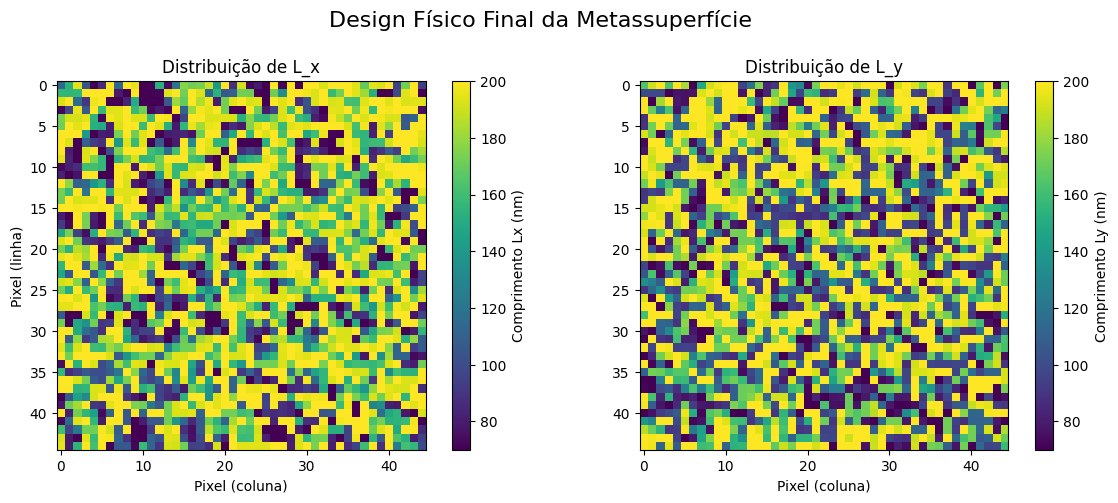

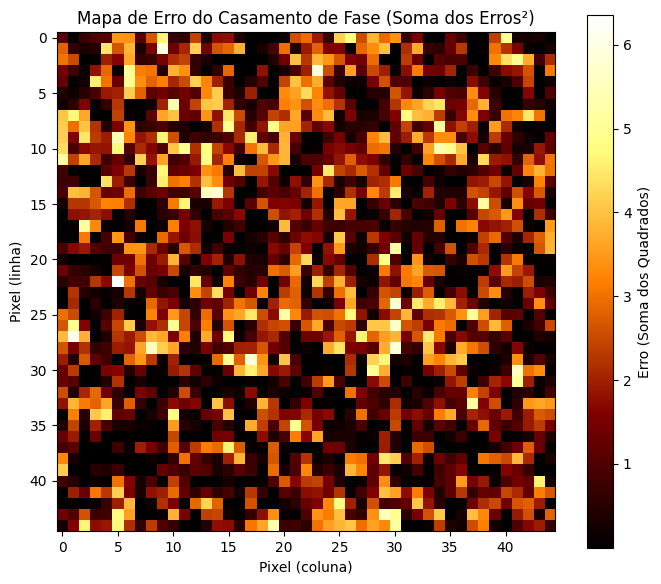

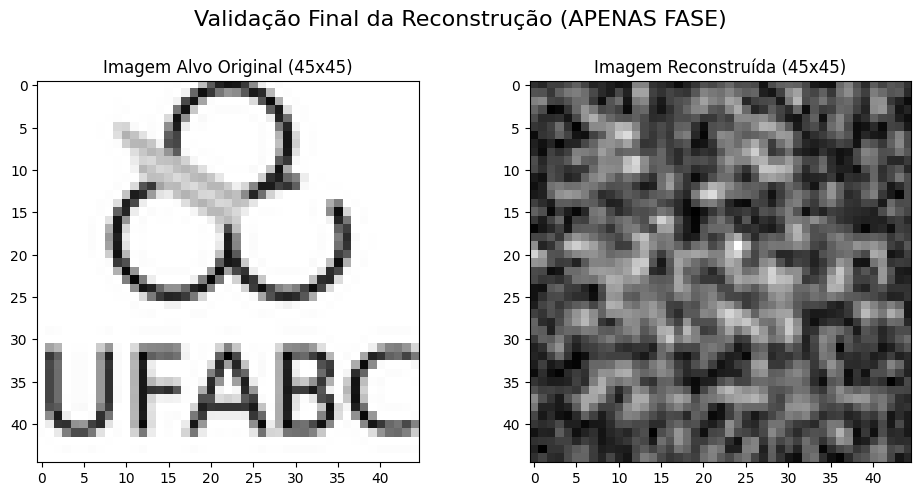

In [9]:
# ===================================================================
# --- Bloco 4: Execução Principal (Otimização) ---
# ===================================================================

# --- 1. Parâmetros Fixos ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parâmetros de Geração (X - Holograma)
IMG_ALVO_X = '/content/WhatsApp Image 2025-11-06 at 16.18.47.png'
TAMANHO_ALVO_X = (45, 45)
PARAMS_GS_X = {
    'wavelength': 1064e-9, 'z': 380e-6, 'dx': 520e-9, 'NA': 0.65, 'num_iter': 50
}

# Parâmetros de Geração (Y - Dammann)
PARAMS_GS_Y = {
    'P': 520e-9, 'wavelength': 1064e-9, 'supercell_pixels': 45,
    'n_supercells': TAMANHO_ALVO_X[0] // 45, 'iters_gs': 400, 'verbose': True
}
if PARAMS_GS_Y['n_supercells'] == 0:
    PARAMS_GS_Y['n_supercells'] = 1


# Parâmetros de Otimização (PSO)
CAMINHO_SIMULADOR = '/content/simulator_teste_2,.pth'
N_PARTICULAS_PSO = 10
GERACOES_PSO = 200

# Parâmetros dos Operadores do PSO
XL = np.array([70, 70])    # Limite inferior [Lx, Ly]
XU = np.array([200, 200])  # Limite superior [Lx, Ly]
W = 0.7  # Fator de Inércia
C1 = 1.5 # Fator Cognitivo (pessoal)
C2 = 1.5 # Fator Social (global)

# --- 2. Geração dos Mapas de Fase ---
print(f"Usando dispositivo: {device}")

print(f"\n--- Etapa 1: Gerando Fase X (Holograma) de '{IMG_ALVO_X}' ---")
target_image_x = load_and_preprocess_image(IMG_ALVO_X, target_size=TAMANHO_ALVO_X)

# Corrigido para desempacotar os 4 valores que sua função retorna
_, _, target_map_Fase_X, _ = gerchberg_saxton_angular_spectrum(
    target_image_x, **PARAMS_GS_X
)

MAP_H, MAP_W = target_map_Fase_X.shape
print(f"Mapa X gerado: {target_map_Fase_X.shape}")

print(f"\n--- Etapa 2: Gerando Fase Y (Dammann) ---")
target_map_Fase_Y, _, _ = generate_dammann_phase_map(**PARAMS_GS_Y)
if target_map_Fase_Y.shape[0] > MAP_H:
     target_map_Fase_Y = target_map_Fase_Y[:MAP_H, :MAP_W]
print(f"Mapa Y final (ajustado): {target_map_Fase_Y.shape}")


# --- 3. Carregar Simulador ---
print(f"\n--- Etapa 3: Carregando simulador de '{CAMINHO_SIMULADOR}' ---")
if not os.path.exists(CAMINHO_SIMULADOR):
    print(f"ERRO: Arquivo do simulador '{CAMINHO_SIMULADOR}' não encontrado.")
    raise FileNotFoundError(f"Arquivo do simulador não encontrado: {CAMINHO_SIMULADOR}")

# Assume que ResNetSimulator já está definido em células anteriores
simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
simulator.load_state_dict(torch.load(CAMINHO_SIMULADOR, map_location=device))
simulator.eval()
print("Simulador carregado.")

# --- 4. Iniciar Otimização ---
print(f"\n--- Etapa 4: Iniciando otimização pixel-a-pixel (PSO Custom - Phase-Only) ---")
print(f"Tamanho do mapa: {MAP_H}x{MAP_W} ({MAP_H*MAP_W} pixels)")
print(f"Parâmetros PSO: {N_PARTICULAS_PSO} partículas, {GERACOES_PSO} gerações por pixel")

metasurface_design_Lx = np.zeros((MAP_H, MAP_W))
metasurface_design_Ly = np.zeros((MAP_H, MAP_W))
metasurface_pixel_errors = np.zeros((MAP_H, MAP_W))

start_time_total = time.time()

# Loop principal de otimização (pixel a pixel)
for r in tqdm(range(MAP_H), desc="Otimizando Linhas"):
    for c in range(MAP_W):
        t_F_x = target_map_Fase_X[r, c]
        t_F_y = target_map_Fase_Y[r, c]

        # Chama a função run_pso_for_pixel (definida na célula anterior)
        best_geometry, best_error = run_pso_for_pixel(
            simulator=simulator,
            device=device,
            target_F_x=t_F_x,
            target_F_y=t_F_y,
            n_particles=N_PARTICULAS_PSO,
            n_generations=GERACOES_PSO,
            xl=XL,
            xu=XU,
            w=W, c1=C1, c2=C2
        )

        metasurface_design_Lx[r, c] = best_geometry[0]
        metasurface_design_Ly[r, c] = best_geometry[1]
        metasurface_pixel_errors[r, c] = best_error

end_time_total = time.time()
total_time_min = (end_time_total - start_time_total) / 60
print(f"\nOtimização de {MAP_H*MAP_W} pixels concluída em {total_time_min:.2f} minutos.")

# --- 5. Salvar Resultados ---
print("Salvando design final...")
np.save("metasurface_design_Lx_final.npy", metasurface_design_Lx)
np.save("metasurface_design_Ly_final.npy", metasurface_design_Ly)
np.save("metasurface_pixel_errors_final.npy", metasurface_pixel_errors)
print("Resultados salvos.")

# --- 6. Gerar e Salvar Gráficos ---
print("\n--- Etapa 5: Gerando gráficos dos resultados ---")

final_Lx = np.load("metasurface_design_Lx_final.npy")
final_Ly = np.load("metasurface_design_Ly_final.npy")
final_errors = np.load("metasurface_pixel_errors_final.npy")

# --- Gráfico 1: Design Físico (Lx e Ly) ---
vmin_val = 70
vmax_val = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Design Físico Final da Metassuperfície", fontsize=16)
im1 = ax1.imshow(final_Lx, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
ax1.set_title("Distribuição de L_x")
ax1.set_xlabel("Pixel (coluna)")
ax1.set_ylabel("Pixel (linha)")
fig.colorbar(im1, ax=ax1, label="Comprimento Lx (nm)")
im2 = ax2.imshow(final_Ly, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
ax2.set_title("Distribuição de L_y")
ax2.set_xlabel("Pixel (coluna)")
fig.colorbar(im2, ax=ax2, label="Comprimento Ly (nm)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plot_design_fisico_final.png")
print("Gráfico 'plot_design_fisico_final.png' salvo.")

# --- Gráfico 2: Mapa de Erro ---
plt.figure(figsize=(7, 6))
plt.imshow(final_errors, cmap='afmhot')
plt.title("Mapa de Erro do Casamento de Fase (Soma dos Erros²)")
plt.xlabel("Pixel (coluna)")
plt.ylabel("Pixel (linha)")
plt.colorbar(label="Erro (Soma dos Quadrados)")
plt.tight_layout()
plt.savefig("plot_mapa_erro_final.png")
print("Gráfico 'plot_mapa_erro_final.png' salvo.")

# --- Gráfico 3: Validação da Reconstrução (Phase-Only) ---
print("Iniciando validação da reconstrução (pode levar um momento)...")

achieved_phase_X = np.zeros((MAP_H, MAP_W))
simulator.eval()
with torch.no_grad():
    for r in tqdm(range(MAP_H), desc="  Validando design", leave=False):
        for c in range(MAP_H):
            L_x_nm = final_Lx[r, c]
            L_y_nm = final_Ly[r, c]
            img_np = draw_meta_atom_ellipse(L_x_nm, L_y_nm)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)
            preds = simulator(img_tensor)
            achieved_phase_X[r, c] = preds[0, 2].item() # Pega Fase X

# Força a amplitude para 1.0
U_start_plane = np.exp(1j * achieved_phase_X)

U_padded, original_size = apply_zero_padding(U_start_plane)
nx_pad, ny_pad = U_padded.shape
params_x = PARAMS_GS_X
filter_mask = create_low_pass_filter(
    (nx_pad, ny_pad), params_x['wavelength'], params_x['dx'], params_x['NA']
)
U_image_reconstructed = angular_spectrum_propagation(
    U_padded, params_x['wavelength'], params_x['z'], params_x['dx'], filter_mask
)
recon_amplitude_final = np.abs(extract_center(U_image_reconstructed, original_size))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Validação Final da Reconstrução (APENAS FASE)", fontsize=16)
ax1.imshow(target_image_x, cmap='gray')
ax1.set_title(f"Imagem Alvo Original ({MAP_H}x{MAP_W})")
ax2.imshow(recon_amplitude_final, cmap='gray')
ax2.set_title(f"Imagem Reconstruída ({MAP_H}x{MAP_W})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plot_validacao_reconstrucao_SO_FASE.png")
print("Gráfico 'plot_validacao_reconstrucao_SO_FASE.png' salvo.")
print("--- Geração de gráficos concluída! ---")

print("Script concluído.")

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parâmetros de Geração do Holograma
IMG_ALVO_X = '/content/WhatsApp Image 2025-11-06 at 16.18.47.png'

TAMANHO_ALVO_X = (45, 45) # Tamanho final da metasuperfície

PARAMS_GS_X = {
    'wavelength': 1064e-9, 'z': 380e-6, 'dx': 520e-9, 'NA': 0.65, 'num_iter': 50
}

# Parâmetros de Geração das grades de Dammann
PARAMS_GS_Y = {
    'P': 520e-9, 'wavelength': 1064e-9, 'supercell_pixels': 45,
    'n_supercells': TAMANHO_ALVO_X[0] // 45, 'iters_gs': 400, 'verbose': True
}
if PARAMS_GS_Y['n_supercells'] == 0:
    PARAMS_GS_Y['n_supercells'] = 1


# Parâmetros de Otimização (AG)
CAMINHO_SIMULADOR = '/content/simulator_teste_2,.pth'
POP_SIZE_AG = 10
GERACOES_AG = 200

# Parâmetros dos Operadores do AG
XL = np.array([70, 70])    # Limite inferior [Lx, Ly]
XU = np.array([200, 200])  # Limite superior [Lx, Ly]
MUTATION_STRENGTH = (XU[0] - XL[0]) * 0.1 # Mutação com 10% da faixa de busca

# Geração dos Mapas de Fase
print(f"Usando dispositivo: {device}")

print(f"\n--- Etapa 1: Gerando Fase X (Holograma) de '{IMG_ALVO_X}' ---")
target_image_x = load_and_preprocess_image(IMG_ALVO_X, target_size=TAMANHO_ALVO_X)
_, _, target_map_Fase_X, _ = gerchberg_saxton_angular_spectrum(
    target_image_x, **PARAMS_GS_X
)
MAP_H, MAP_W = target_map_Fase_X.shape
print(f"Mapa X gerado: {target_map_Fase_X.shape}")

print(f"\n--- Etapa 2: Gerando Fase Y (Dammann) ---")
target_map_Fase_Y, _, _ = generate_dammann_phase_map(**PARAMS_GS_Y)
if target_map_Fase_Y.shape[0] > MAP_H:
     target_map_Fase_Y = target_map_Fase_Y[:MAP_H, :MAP_W]
print(f"Mapa Y final (ajustado): {target_map_Fase_Y.shape}")


# --- 3. Carregar Simulador ---
print(f"\n--- Etapa 3: Carregando simulador de '{CAMINHO_SIMULADOR}' ---")
if not os.path.exists(CAMINHO_SIMULADOR):
    print(f"ERRO: Arquivo do simulador '{CAMINHO_SIMULADOR}' não encontrado.")
    raise FileNotFoundError(f"Arquivo do simulador não encontrado: {CAMINHO_SIMULADOR}")

simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
simulator.load_state_dict(torch.load(CAMINHO_SIMULADOR, map_location=device))
simulator.eval()
print("Simulador carregado.")

# --- 4. Iniciar Otimização ---
print(f"\n--- Etapa 4: Iniciando otimização pixel-a-pixel (AG Custom) ---")
print(f"Tamanho do mapa: {MAP_H}x{MAP_W} ({MAP_H*MAP_W} pixels)")
print(f"Parâmetros AG: {POP_SIZE_AG} indivíduos, {GERACOES_AG} gerações por pixel")

metasurface_design_Lx = np.zeros((MAP_H, MAP_W))
metasurface_design_Ly = np.zeros((MAP_H, MAP_W))
metasurface_pixel_errors = np.zeros((MAP_H, MAP_W)) # Erro 2D (Single-Objective)

start_time_total = time.time()

# Loop principal de otimização (pixel a pixel)
for r in tqdm(range(MAP_H), desc="Otimizando Linhas"):
    for c in range(MAP_W):
        # Alvos para este pixel
        t_F_x = target_map_Fase_X[r, c]
        t_F_y = target_map_Fase_Y[r, c]

        # Roda o AG "do zero" para este pixel
        best_geometry, best_error = run_ga_for_pixel(
            simulator=simulator,
            device=device,
            target_F_x=t_F_x,
            target_F_y=t_F_y,
            pop_size=POP_SIZE_AG,
            n_generations=GERACOES_AG,
            xl=XL,
            xu=XU,
            mut_strength=MUTATION_STRENGTH
        )

        # Salva o melhor resultado
        metasurface_design_Lx[r, c] = best_geometry[0]
        metasurface_design_Ly[r, c] = best_geometry[1]
        metasurface_pixel_errors[r, c] = best_error

end_time_total = time.time()
total_time_min = (end_time_total - start_time_total) / 60
print(f"\nOtimização de {MAP_H*MAP_W} pixels concluída em {total_time_min:.2f} minutos.")

# --- 5. Salvar Resultados ---
print("Salvando design final...")
np.save("metasurface_design_Lx_final.npy", metasurface_design_Lx)
np.save("metasurface_design_Ly_final.npy", metasurface_design_Ly)
np.save("metasurface_pixel_errors_final.npy", metasurface_pixel_errors)
print("Resultados salvos.")

# --- 6. Gerar e Salvar Gráficos ---
print("\n--- Etapa 5: Gerando gráficos dos resultados ---")

final_Lx = np.load("metasurface_design_Lx_final.npy")
final_Ly = np.load("metasurface_design_Ly_final.npy")
final_errors = np.load("metasurface_pixel_errors_final.npy")

# --- Gráfico 1: Design Físico (Lx e Ly) ---
vmin_val = 70
vmax_val = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Design Físico Final da Metassuperfície", fontsize=16)
im1 = ax1.imshow(final_Lx, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
ax1.set_title("Distribuição de L_x")
ax1.set_xlabel("Pixel (coluna)")
ax1.set_ylabel("Pixel (linha)")
fig.colorbar(im1, ax=ax1, label="Comprimento Lx (nm)")
im2 = ax2.imshow(final_Ly, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
ax2.set_title("Distribuição de L_y")
ax2.set_xlabel("Pixel (coluna)")
fig.colorbar(im2, ax=ax2, label="Comprimento Ly (nm)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plot_design_fisico_final.png")
print("Gráfico 'plot_design_fisi co_final.png' salvo.")

# --- Gráfico 2: Mapa de Erro ---
plt.figure(figsize=(7, 6))
plt.imshow(final_errors, cmap='afmhot')
plt.title("Mapa de Erro do Casamento de Fase (Soma dos Erros²)")
plt.xlabel("Pixel (coluna)")
plt.ylabel("Pixel (linha)")
plt.colorbar(label="Erro (Soma dos Quadrados)")
plt.tight_layout()
plt.savefig("plot_mapa_erro_final.png")
print("Gráfico 'plot_mapa_erro_final.png' salvo.")

# --- Gráfico 3: Validação da Reconstrução ---
print("Iniciando validação da reconstrução (pode levar um momento)...")
achieved_phase_X = np.zeros((MAP_H, MAP_W))
# achieved_amplitude_X não é mais necessário
simulator.eval()
with torch.no_grad():
    for r in tqdm(range(MAP_H), desc="  Validando design", leave=False):
        for c in range(MAP_W):
            L_x_nm = final_Lx[r, c]
            L_y_nm = final_Ly[r, c]
            img_np = draw_meta_atom_ellipse(L_x_nm, L_y_nm)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)
            preds = simulator(img_tensor)
            # Não armazenamos mais a amplitude (preds[0, 0])
            achieved_phase_X[r, c] = preds[0, 2].item() # Pega a Fase X

# --- CORREÇÃO APLICADA AQUI ---
# Constrói o campo inicial forçando a amplitude para 1.0 em todos os pixels
# e usando apenas a fase que o AG otimizou.
U_start_plane = np.exp(1j * achieved_phase_X)
# --- FIM DA CORREÇÃO ---

U_padded, original_size = apply_zero_padding(U_start_plane)
nx_pad, ny_pad = U_padded.shape
params_x = PARAMS_GS_X
filter_mask = create_low_pass_filter(
    (nx_pad, ny_pad), params_x['wavelength'], params_x['dx'], params_x['NA']
)
U_image_reconstructed = angular_spectrum_propagation(
    U_padded, params_x['wavelength'], params_x['z'], params_x['dx'], filter_mask
)
recon_amplitude_final = np.abs(extract_center(U_image_reconstructed, original_size))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Validação Final da Reconstrução (APENAS FASE)", fontsize=16)
ax1.imshow(target_image_x, cmap='gray')
ax1.set_title(f"Imagem Alvo Original ({MAP_H}x{MAP_W})")
ax2.imshow(recon_amplitude_final, cmap='gray')
ax2.set_title(f"Imagem Reconstruída ({MAP_H}x{MAP_W})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plot_validacao_reconstrucao_SO_FASE.png")
print("Gráfico 'plot_validacao_reconstrucao_SO_FASE.png' salvo.")
print("--- Geração de gráficos concluída! ---")

print("Script concluído.")

Usando dispositivo: cuda

--- Etapa 1: Gerando Fase X (Holograma) de '/content/WhatsApp Image 2025-11-06 at 16.18.47.png' ---
 	Iteração GS (X) 10/50, Correlação: 0.6265
 	Iteração GS (X) 20/50, Correlação: 0.6729
 	Iteração GS (X) 30/50, Correlação: 0.6868
 	Iteração GS (X) 40/50, Correlação: 0.6967
 	Iteração GS (X) 50/50, Correlação: 0.7025
Mapa X gerado: (45, 45)

--- Etapa 2: Gerando Fase Y (Dammann) ---


  Mapa Dammann (Y) gerado: (45, 45) pixels
Mapa Y final (ajustado): (45, 45)

--- Etapa 3: Carregando simulador de '/content/simulator_teste_2,.pth' ---
Simulador carregado.

--- Etapa 4: Iniciando otimização pixel-a-pixel (AG Custom) ---
Tamanho do mapa: 45x45 (2025 pixels)
Parâmetros AG: 10 indivíduos, 200 gerações por pixel


Otimizando Linhas:   0%|          | 0/45 [00:00<?, ?it/s]


NameError: name 'run_ga_for_pixel' is not defined

In [ ]:
# if __name__ == "__main__":

#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     # Parâmetros de Geração do Holograma
#     IMG_ALVO_X = '/content/WhatsApp Image 2025-11-06 at 16.18.47.png'

#     TAMANHO_ALVO_X = (45, 45) # Tamanho final da metasuperfície

#     PARAMS_GS_X = {
#         'wavelength': 1064e-9, 'z': 380e-6, 'dx': 520e-9, 'NA': 0.65, 'num_iter': 50
#     }

#     # Parâmetros de Geração das grades de Dammann
#     PARAMS_GS_Y = {
#         'P': 520e-9, 'wavelength': 1064e-9, 'supercell_pixels': 45,
#         'n_supercells': TAMANHO_ALVO_X[0] // 45, 'iters_gs': 400, 'verbose': True
#     }
#     if PARAMS_GS_Y['n_supercells'] == 0:
#         PARAMS_GS_Y['n_supercells'] = 1


#     # Parâmetros de Otimização (AG)
#     CAMINHO_SIMULADOR = '/content/simulator_teste_2,.pth'
#     POP_SIZE_AG = 20
#     GERACOES_AG = 40

#     # Parâmetros dos Operadores do AG
#     XL = np.array([70, 70])    # Limite inferior [Lx, Ly]
#     XU = np.array([200, 200])  # Limite superior [Lx, Ly]
#     MUTATION_STRENGTH = (XU[0] - XL[0]) * 0.1 # Mutação com 10% da faixa de busca

#     # Geração dos Mapas de Fase
#     print(f"Usando dispositivo: {device}")

#     print(f"\n--- Etapa 1: Gerando Fase X (Holograma) de '{IMG_ALVO_X}' ---")
#     target_image_x = load_and_preprocess_image(IMG_ALVO_X, target_size=TAMANHO_ALVO_X)
#     target_map_Fase_X, _ = gerchberg_saxton_angular_spectrum(
#         target_image_x, **PARAMS_GS_X
#     )
#     MAP_H, MAP_W = target_map_Fase_X.shape
#     print(f"Mapa X gerado: {target_map_Fase_X.shape}")

#     print(f"\n--- Etapa 2: Gerando Fase Y (Dammann) ---")
#     target_map_Fase_Y, _, _ = generate_dammann_phase_map(**PARAMS_GS_Y)
#     if target_map_Fase_Y.shape[0] > MAP_H:
#          target_map_Fase_Y = target_map_Fase_Y[:MAP_H, :MAP_W]
#     print(f"Mapa Y final (ajustado): {target_map_Fase_Y.shape}")


#     # --- 3. Carregar Simulador ---
#     print(f"\n--- Etapa 3: Carregando simulador de '{CAMINHO_SIMULADOR}' ---")
#     if not os.path.exists(CAMINHO_SIMULADOR):
#         print(f"ERRO: Arquivo do simulador '{CAMINHO_SIMULADOR}' não encontrado.")
#         # Em um script, usaríamos exit(). No notebook, podemos parar aqui.
#         raise FileNotFoundError(f"Arquivo do simulador não encontrado: {CAMINHO_SIMULADOR}")

#     simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
#     simulator.load_state_dict(torch.load(CAMINHO_SIMULADOR, map_location=device))
#     simulator.eval()
#     print("Simulador carregado.")

#     # --- 4. Iniciar Otimização ---
#     print(f"\n--- Etapa 4: Iniciando otimização pixel-a-pixel (AG Custom) ---")
#     print(f"Tamanho do mapa: {MAP_H}x{MAP_W} ({MAP_H*MAP_W} pixels)")
#     print(f"Parâmetros AG: {POP_SIZE_AG} indivíduos, {GERACOES_AG} gerações por pixel")

#     metasurface_design_Lx = np.zeros((MAP_H, MAP_W))
#     metasurface_design_Ly = np.zeros((MAP_H, MAP_W))
#     metasurface_pixel_errors = np.zeros((MAP_H, MAP_W)) # Erro 2D (Single-Objective)

#     start_time_total = time.time()

#     # Loop principal de otimização (pixel a pixel)
#     for r in tqdm(range(MAP_H), desc="Otimizando Linhas"):
#         for c in range(MAP_W):
#             # Alvos para este pixel
#             t_F_x = target_map_Fase_X[r, c]
#             t_F_y = target_map_Fase_Y[r, c]

#             # Roda o AG "do zero" para este pixel
#             best_geometry, best_error = run_ga_for_pixel(
#                 simulator=simulator,
#                 device=device,
#                 target_F_x=t_F_x,
#                 target_F_y=t_F_y,
#                 pop_size=POP_SIZE_AG,
#                 n_generations=GERACOES_AG,
#                 xl=XL,
#                 xu=XU,
#                 mut_strength=MUTATION_STRENGTH
#             )

#             # Salva o melhor resultado
#             metasurface_design_Lx[r, c] = best_geometry[0]
#             metasurface_design_Ly[r, c] = best_geometry[1]
#             metasurface_pixel_errors[r, c] = best_error

#     end_time_total = time.time()
#     total_time_min = (end_time_total - start_time_total) / 60
#     print(f"\nOtimização de {MAP_H*MAP_W} pixels concluída em {total_time_min:.2f} minutos.")

#     # --- 5. Salvar Resultados ---
#     # (Sem alterações)
#     print("Salvando design final...")
#     np.save("metasurface_design_Lx_final.npy", metasurface_design_Lx)
#     np.save("metasurface_design_Ly_final.npy", metasurface_design_Ly)
#     np.save("metasurface_pixel_errors_final.npy", metasurface_pixel_errors)
#     print("Resultados salvos.")

#     # --- 6. Gerar e Salvar Gráficos ---
#     # (Sem alterações)
#     print("\n--- Etapa 5: Gerando gráficos dos resultados ---")

#     final_Lx = np.load("metasurface_design_Lx_final.npy")
#     final_Ly = np.load("metasurface_design_Ly_final.npy")
#     final_errors = np.load("metasurface_pixel_errors_final.npy")

#     # --- Gráfico 1: Design Físico (Lx e Ly) ---
#     vmin_val = 70
#     vmax_val = 200
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#     fig.suptitle("Design Físico Final da Metassuperfície", fontsize=16)
#     im1 = ax1.imshow(final_Lx, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
#     ax1.set_title("Distribuição de L_x")
#     ax1.set_xlabel("Pixel (coluna)")
#     ax1.set_ylabel("Pixel (linha)")
#     fig.colorbar(im1, ax=ax1, label="Comprimento Lx (nm)")
#     im2 = ax2.imshow(final_Ly, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
#     ax2.set_title("Distribuição de L_y")
#     ax2.set_xlabel("Pixel (coluna)")
#     fig.colorbar(im2, ax=ax2, label="Comprimento Ly (nm)")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig("plot_design_fisico_final.png")
#     print("Gráfico 'plot_design_fisico_final.png' salvo.")

#     # --- Gráfico 2: Mapa de Erro ---
#     plt.figure(figsize=(7, 6))
#     plt.imshow(final_errors, cmap='afmhot')
#     plt.title("Mapa de Erro do Casamento de Fase (Soma dos Erros²)")
#     plt.xlabel("Pixel (coluna)")
#     plt.ylabel("Pixel (linha)")
#     plt.colorbar(label="Erro (Soma dos Quadrados)")
#     plt.tight_layout()
#     plt.savefig("plot_mapa_erro_final.png")
#     print("Gráfico 'plot_mapa_erro_final.png' salvo.")

#     # --- Gráfico 3: Validação da Reconstrução ---
#     print("Iniciando validação da reconstrução (pode levar um momento)...")
#     achieved_phase_X = np.zeros((MAP_H, MAP_W))
#     achieved_amplitude_X = np.zeros((MAP_H, MAP_W))
#     simulator.eval()
#     with torch.no_grad():
#         for r in tqdm(range(MAP_H), desc="  Validando design", leave=False):
#             for c in range(MAP_W):
#                 L_x_nm = final_Lx[r, c]
#                 L_y_nm = final_Ly[r, c]
#                 img_np = draw_meta_atom_ellipse(L_x_nm, L_y_nm)
#                 img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)
#                 preds = simulator(img_tensor)
#                 achieved_amplitude_X[r, c] = preds[0, 0].item()
#                 achieved_phase_X[r, c] = preds[0, 2].item()

#     U_start_plane = achieved_amplitude_X * np.exp(1j * achieved_phase_X)
#     U_padded, original_size = apply_zero_padding(U_start_plane)
#     nx_pad, ny_pad = U_padded.shape
#     params_x = PARAMS_GS_X
#     filter_mask = create_low_pass_filter(
#         (nx_pad, ny_pad), params_x['wavelength'], params_x['dx'], params_x['NA']
#     )
#     U_image_reconstructed = angular_spectrum_propagation(
#         U_padded, params_x['wavelength'], params_x['z'], params_x['dx'], filter_mask
#     )
#     recon_amplitude_final = np.abs(extract_center(U_image_reconstructed, original_size))
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#     fig.suptitle("Validação Final da Reconstrução (Polarização X)", fontsize=16)
#     ax1.imshow(target_image_x, cmap='gray')
#     ax1.set_title(f"Imagem Alvo Original ({MAP_H}x{MAP_W})")
#     ax2.imshow(recon_amplitude_final, cmap='gray')
#     ax2.set_title(f"Imagem Reconstruída ({MAP_H}x{MAP_W})")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig("plot_validacao_reconstrucao.png")
#     print("Gráfico 'plot_validacao_reconstrucao.png' salvo.")
#     print("--- Geração de gráficos concluída! ---")

#     print("Script concluído.")